In [37]:
import os
import glob
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Learning Rate

In [6]:
EXPERIMENT_TOTEST = "panasonic-hyper-0.0.4"
test_results = pd.read_csv(f"..//logs//{EXPERIMENT_TOTEST}//test_results.csv")

In [7]:
# Append learning rate to test results
lr_dfs = []
hyper_folders = glob.glob(f"..//logs//{EXPERIMENT_TOTEST}//train_*")[0]
for trial_folder in glob.glob(f"{hyper_folders}//trial_*"):
    with open(f"{trial_folder}//params.json", "r") as f:
        lr = json.load(f)["lr"]
        trial_name = os.path.basename(trial_folder)
        lr_dfs += [pd.DataFrame([{"trial": trial_name, "lr": lr}])]
merged_df = pd.merge(test_results, pd.concat(lr_dfs), on='trial')

In [8]:
merged_df

,trial,0degC,-10degC,-20degC,10degC,25degC,Average_MAE,lr
0,trial_d1265_00000,1.920,2.588,3.651,1.727,1.405,2.2582,0.000021
1,trial_d1265_00001,1.344,2.170,1.771,1.198,0.932,1.4830,0.000186
2,trial_d1265_00002,1.874,2.376,3.162,1.690,1.567,2.1338,0.000009
3,trial_d1265_00003,1.595,2.173,2.170,1.281,1.149,1.6736,0.000028
4,trial_d1265_00004,2.567,3.868,6.726,2.719,3.100,3.7960,0.000005
...,...,...,...,...,...,...,...,...
95,trial_d1265_00095,1.377,2.198,1.778,1.281,0.959,1.5186,0.000113
96,trial_d1265_00096,0.732,2.778,1.261,0.711,0.587,1.2138,0.003126
97,trial_d1265_00097,1.167,2.022,1.479,0.847,0.627,1.2284,0.000666
98,trial_d1265_00098,1.189,2.096,1.369,0.916,0.747,1.2634,0.001193


In [27]:
optim = merged_df[merged_df["Average_MAE"] == min(merged_df["Average_MAE"])]
optim_lr = optim["lr"]
optim_lr

42    0.005374
Name: lr, dtype: float64

In [29]:
optim

,trial,0degC,-10degC,-20degC,10degC,25degC,Average_MAE,lr
42,trial_d1265_00042,0.701,2.433,1.158,0.671,0.521,1.0968,0.005374


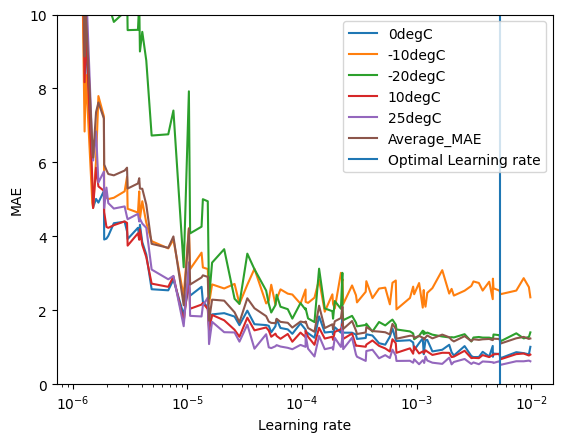

In [28]:
cols = ["0degC", "-10degC", "-20degC", "10degC", "25degC", "Average_MAE"]

for col in cols:
    merged_df = merged_df.sort_values(by='lr', ascending=True)
    plt.plot(merged_df["lr"], merged_df[col], label=col)
    plt.xlabel("Learning rate")
    plt.ylabel("MAE")
    plt.xscale("log")
    plt.ylim(0, 10)
plt.axvline(x = float(optim_lr), label = 'Optimal Learning rate')
plt.legend(loc='upper right')
plt.show()

# DNN Model Architecture

In [4]:
EXPERIMENT_TOTEST = "panasonic-hyper-0.0.5"
test_results = pd.read_csv(f"..//logs//{EXPERIMENT_TOTEST}//test_results.csv")

In [6]:
import torch
import torch.nn as nn

class DynamicNet(nn.Module):
    def __init__(self, n_inputs, layer_sizes):
        super(DynamicNet, self).__init__()

        # input layer
        layers = []
        layer_sizes.insert(0, n_inputs)  # Insert the input size at the beginning

        # Create the hidden layers
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())

        self.layers = nn.ModuleList(layers)

        # output layer
        self.output_layer = nn.Linear(layer_sizes[-1], 1)
        self.output_act = nn.Sigmoid()

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        
        X = self.output_layer(X)
        X = self.output_act(X)
        return X

In [7]:
features = ['Voltage', 'Current', 'Power', 'Battery_Temp_degC', 'Voltage_MA1000', 'Current_MA1000', 'Voltage_MA400', 'Current_MA400', 'Voltage_MA200', 'Current_MA200', 'Voltage_MA100', 'Current_MA100', 'Voltage_MA50', 'Current_MA50', 'Voltage_MA10', 'Current_MA10']

In [10]:
# Append model size to result
model_size_dfs = []
hyper_folders = glob.glob(f"..//logs//{EXPERIMENT_TOTEST}//train_*")[0]
for trial_folder in glob.glob(f"{hyper_folders}//trial_*"):
    with open(f"{trial_folder}//params.json", "r") as f:
        model_layer_sizes = json.load(f)["model_layer_sizes"]
        
        model = DynamicNet(n_inputs=len(features), layer_sizes=model_layer_sizes)
        
        pytorch_total_params = sum(p.numel() for p in model.parameters())
        
        trial_name = os.path.basename(trial_folder)
        model_size_dfs += [pd.DataFrame([{"trial": trial_name, "model_size": pytorch_total_params}])]
merged_df = pd.merge(test_results, pd.concat(model_size_dfs), on='trial')

In [11]:
merged_df

,trial,0degC,-10degC,-20degC,10degC,25degC,Average_MAE,model_size
0,trial_429c6_00000,0.546,2.623,0.767,0.558,0.413,0.9814,193633
1,trial_429c6_00001,0.673,2.950,1.065,0.704,0.606,1.1996,107025
2,trial_429c6_00002,0.560,2.652,0.859,0.656,0.489,1.0432,175553
3,trial_429c6_00003,0.593,2.815,0.902,0.573,0.448,1.0662,53825
4,trial_429c6_00004,0.630,2.742,0.980,0.694,0.625,1.1342,141249
...,...,...,...,...,...,...,...,...
95,trial_429c6_00095,0.546,2.768,0.905,0.591,0.442,1.0504,23969
96,trial_429c6_00096,0.727,2.836,1.217,0.811,0.642,1.2466,64641
97,trial_429c6_00097,0.632,2.658,1.020,0.643,0.503,1.0912,257889
98,trial_429c6_00098,0.633,2.275,0.971,0.647,0.507,1.0066,25505


In [13]:
optim = merged_df[merged_df["Average_MAE"] == min(merged_df["Average_MAE"])]
optim

,trial,0degC,-10degC,-20degC,10degC,25degC,Average_MAE,model_size
0,trial_429c6_00000,0.546,2.623,0.767,0.558,0.413,0.9814,193633


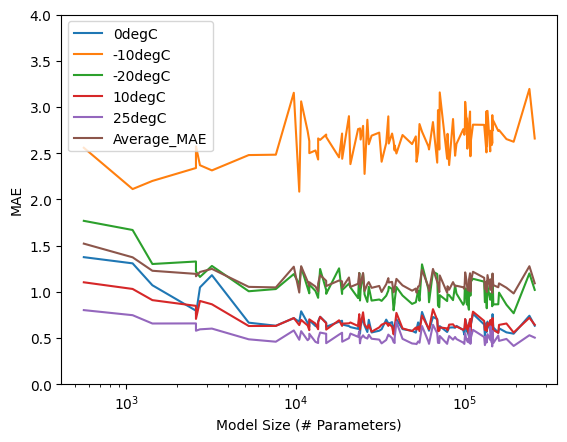

In [18]:
cols = ["0degC", "-10degC", "-20degC", "10degC", "25degC", "Average_MAE"]

for col in cols:
    merged_df = merged_df.sort_values(by='model_size', ascending=True)
    plt.plot(merged_df["model_size"], merged_df[col], label=col)
    plt.xlabel("Model Size (# Parameters)")
    plt.ylabel("MAE")
    plt.xscale("log")
    plt.ylim(0, 4)
plt.legend(loc='upper left')
plt.show()

In [35]:
# Best 10 performing models and their architecture
N_max = 10
for i, (row, trial) in enumerate(merged_df.sort_values(by='Average_MAE', ascending=True).iterrows()):
    trial_folder = f"{hyper_folders}//{trial['trial']}"
    with open(f"{trial_folder}//params.json", "r") as f:
        model_layer_sizes = json.load(f)["model_layer_sizes"]
    
    print(f"Name: {trial['trial']}, Average MAE: {round(trial['Average_MAE'], 3)}, Architecture: {model_layer_sizes}")
    
    if i == N_max-1:
        break

Name: trial_429c6_00000, Average MAE: 0.981, Architecture: [64, 256, 256, 256, 128, 64, 32, 32]
Name: trial_429c6_00049, Average MAE: 0.988, Architecture: [256, 256, 256, 32, 16]
Name: trial_429c6_00066, Average MAE: 0.988, Architecture: [256, 256, 32]
Name: trial_429c6_00009, Average MAE: 0.99, Architecture: [128, 256, 64]
Name: trial_429c6_00047, Average MAE: 0.991, Architecture: [128, 64]
Name: trial_429c6_00024, Average MAE: 0.994, Architecture: [64, 128, 128, 64, 32, 32, 16]
Name: trial_429c6_00084, Average MAE: 0.996, Architecture: [128, 256, 128, 16, 16]
Name: trial_429c6_00063, Average MAE: 0.997, Architecture: [64, 64, 128, 256, 256, 64, 64, 16, 16]
Name: trial_429c6_00007, Average MAE: 0.997, Architecture: [128, 128, 64, 64, 16]
Name: trial_429c6_00010, Average MAE: 1.002, Architecture: [16, 64, 256, 256, 64, 64, 32, 32]


In [36]:
merged_df.sort_values(by='Average_MAE', ascending=True).head(10)

,trial,0degC,-10degC,-20degC,10degC,25degC,Average_MAE,model_size
0,trial_429c6_00000,0.546,2.623,0.767,0.558,0.413,0.9814,193633
49,trial_429c6_00049,0.544,2.606,0.843,0.539,0.408,0.9880,144705
66,trial_429c6_00066,0.564,2.439,0.899,0.603,0.436,0.9882,78401
9,trial_429c6_00009,0.595,2.406,0.924,0.590,0.433,0.9896,51713
47,trial_429c6_00047,0.675,2.083,1.080,0.639,0.480,0.9914,10497
24,trial_429c6_00024,0.552,2.627,0.799,0.538,0.454,0.9940,37857
84,trial_429c6_00084,0.584,2.539,0.832,0.579,0.445,0.9958,70449
63,trial_429c6_00063,0.565,2.573,0.821,0.575,0.452,0.9972,134321
7,trial_429c6_00007,0.594,2.407,0.901,0.643,0.441,0.9972,32161
10,trial_429c6_00010,0.587,2.466,0.957,0.563,0.436,1.0018,107569
